# Notes

Readings:
- https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/ - SARIMAX realisation in python
- https://python.quantecon.org/pandas_panel.html - quite intersting guide on Panel Data in Python

# Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from prophet import Prophet

In [3]:
# Default fig size
plt.rc('figure', figsize=(16,8))

# Read Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv', index_col='id', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv', index_col='id', parse_dates=['date'])

# Quick overlook

In [5]:
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [6]:
test.head()

,date,country,store,product
id,,,,
136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


For this challenge, you will be predicting a full year worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the task of predicting sales during for year 2022.

# Check Dtypes

In reality I looked at .info and then added specification on the first step when read_csv()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27375 entries, 136950 to 164324
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     27375 non-null  datetime64[ns]
 1   country  27375 non-null  object        
 2   store    27375 non-null  object        
 3   product  27375 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.0+ MB


Now look fine.

# Is Data balanced or not ?

I will transform data into panal

In [9]:
panel_train = train.pivot(values=['num_sold'],index=['date'],columns=['country', 'store', 'product'])
test['num_sold'] = pd.NA
panel_test = test.pivot(values=['num_sold'],index=['date'],columns=['country', 'store', 'product'])

In [10]:
panel_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 75 columns):
 #   Column                                                                               Non-Null Count  Dtype
---  ------                                                                               --------------  -----
 0   (num_sold, Argentina, Kaggle Learn, Using LLMs to Improve Your Coding)               1826 non-null   int64
 1   (num_sold, Argentina, Kaggle Learn, Using LLMs to Train More LLMs)                   1826 non-null   int64
 2   (num_sold, Argentina, Kaggle Learn, Using LLMs to Win Friends and Influence People)  1826 non-null   int64
 3   (num_sold, Argentina, Kaggle Learn, Using LLMs to Win More Kaggle Competitions)      1826 non-null   int64
 4   (num_sold, Argentina, Kaggle Learn, Using LLMs to Write Better)                      1826 non-null   int64
 5   (num_sold, Argentina, Kaggle Store, Using LLMs to Improve Your Coding)               1

In [11]:
panel_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 75 columns):
 #   Column                                                                               Non-Null Count  Dtype 
---  ------                                                                               --------------  ----- 
 0   (num_sold, Argentina, Kaggle Learn, Using LLMs to Improve Your Coding)               0 non-null      object
 1   (num_sold, Argentina, Kaggle Learn, Using LLMs to Train More LLMs)                   0 non-null      object
 2   (num_sold, Argentina, Kaggle Learn, Using LLMs to Win Friends and Influence People)  0 non-null      object
 3   (num_sold, Argentina, Kaggle Learn, Using LLMs to Win More Kaggle Competitions)      0 non-null      object
 4   (num_sold, Argentina, Kaggle Learn, Using LLMs to Write Better)                      0 non-null      object
 5   (num_sold, Argentina, Kaggle Store, Using LLMs to Improve Your Coding)          

The data looks balanced, so we do not create any strategy to fill in the gaps

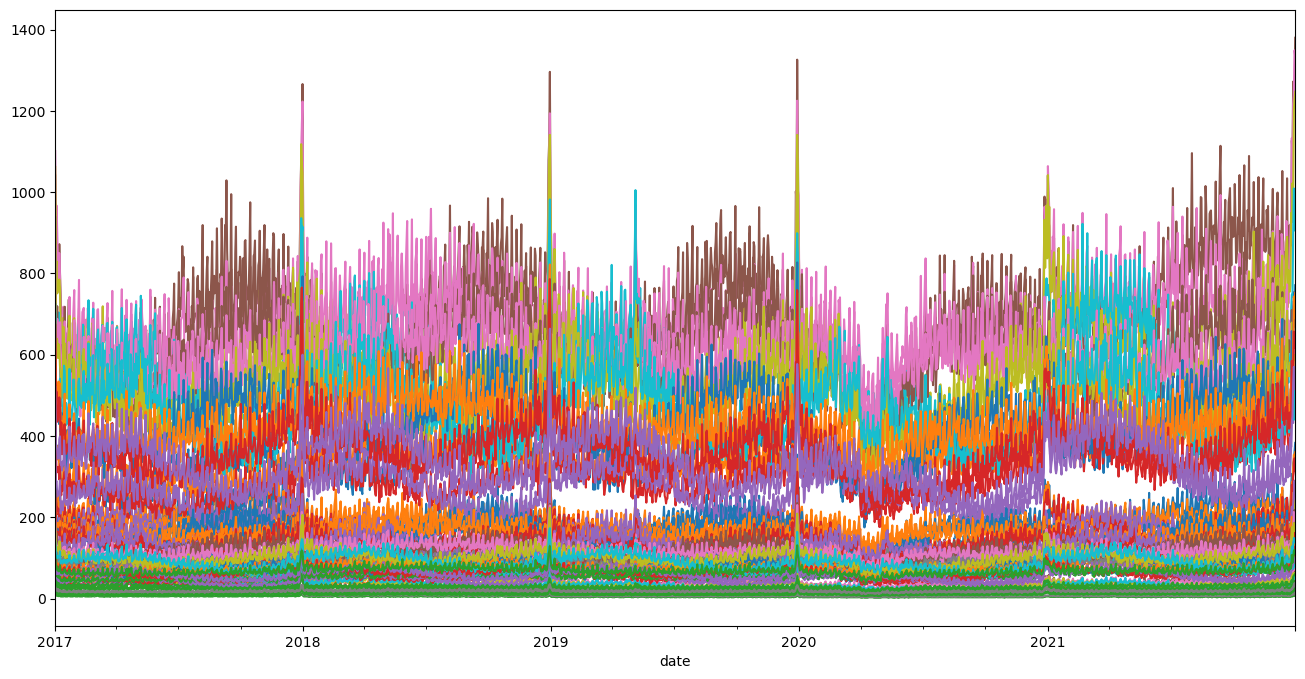

In [12]:
fig, ax = plt.subplots()

panel_train.plot(ax=ax)

ax.legend().set_visible(False)

plt.show()

Looks difference stationary.

# Q&A

How many countries do we have ?

In [13]:
print(train['country'].nunique())

5


In [14]:
print(train['store'].nunique())

3


In [15]:
print(train['product'].nunique())

5


In [16]:
5*3*5 # Which is exactly the number of columns in Pivot table

75

So we have even number of products stores and countries

# Look on the Sales across each Country Level

  0%|          | 0/5 [00:00<?, ?it/s]

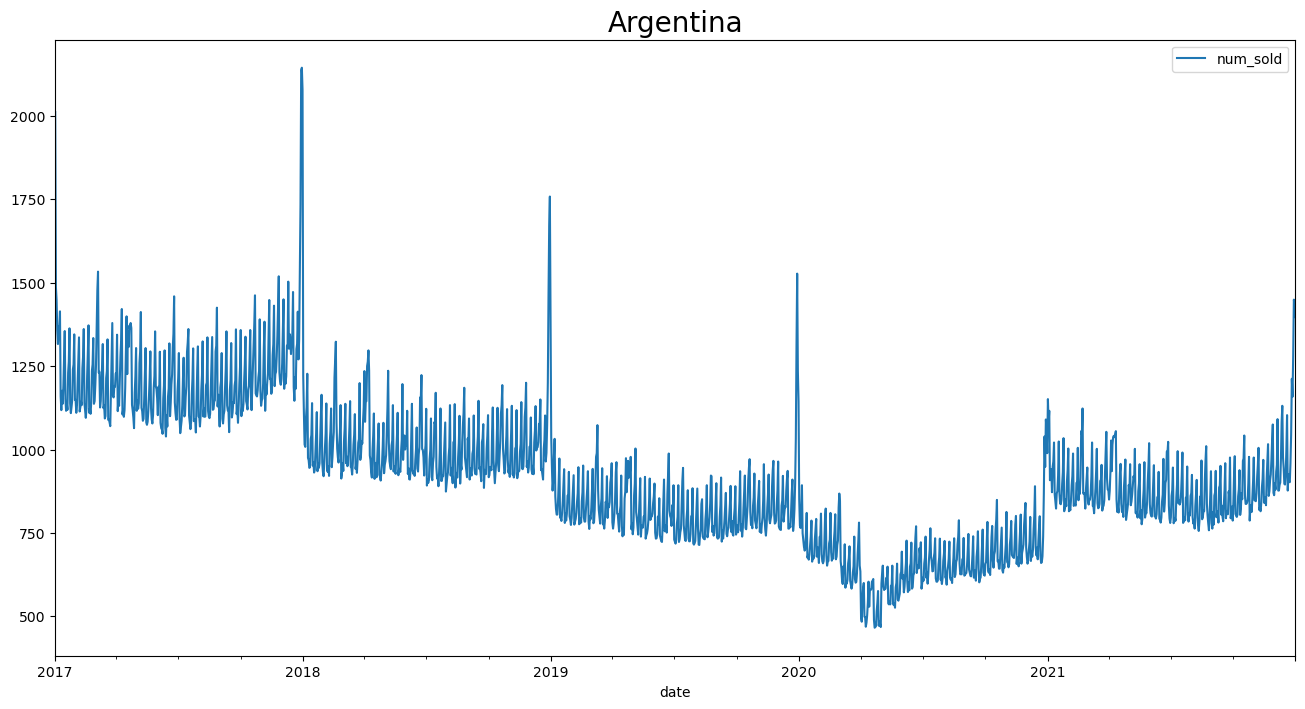

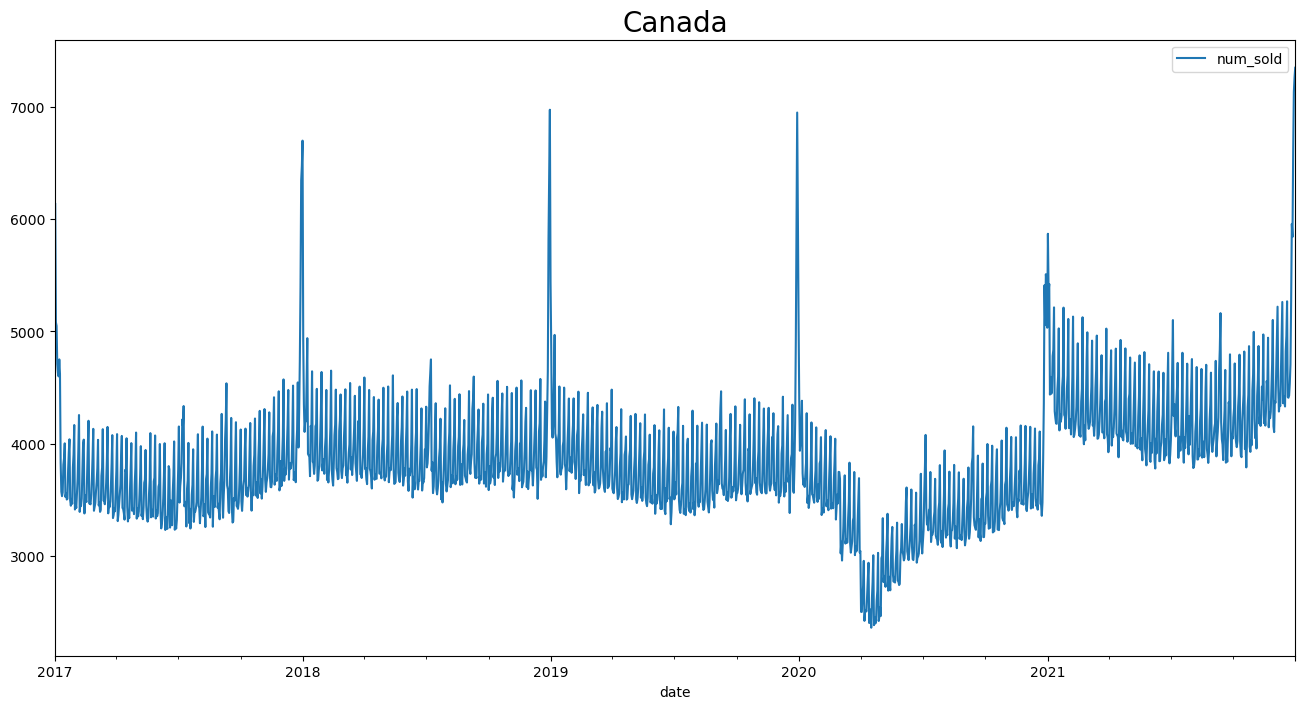

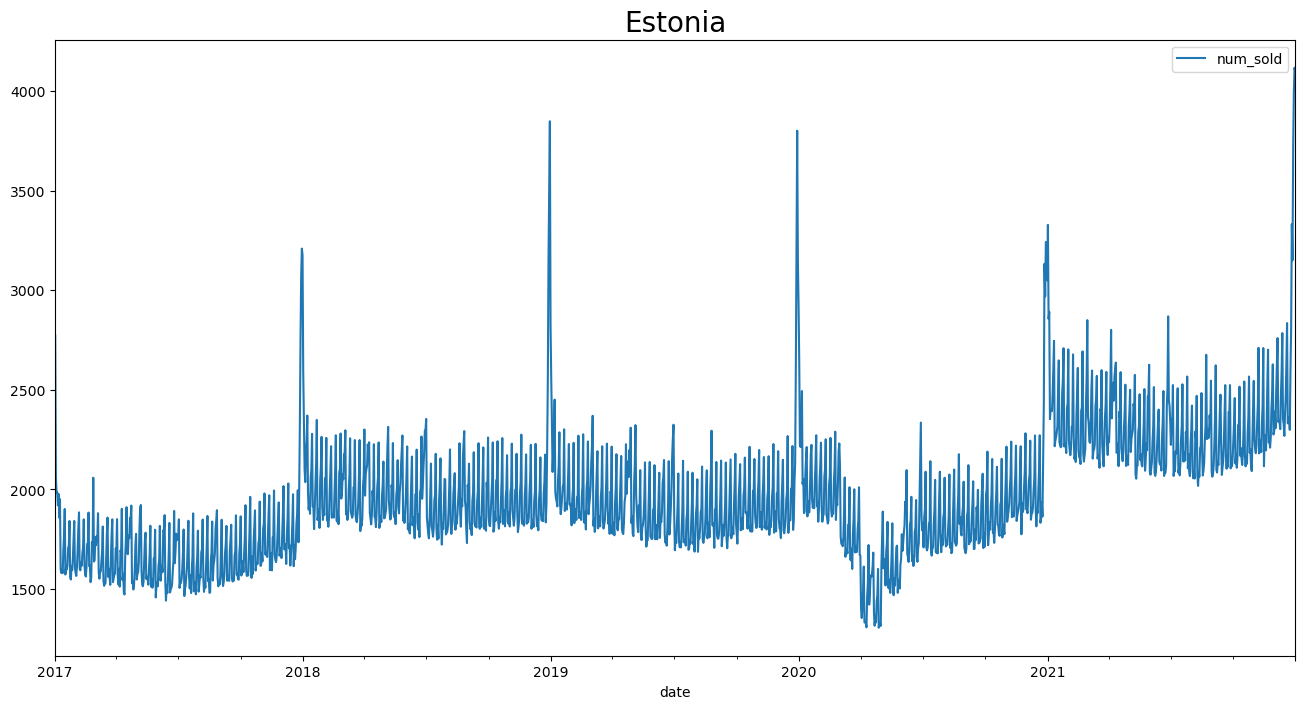

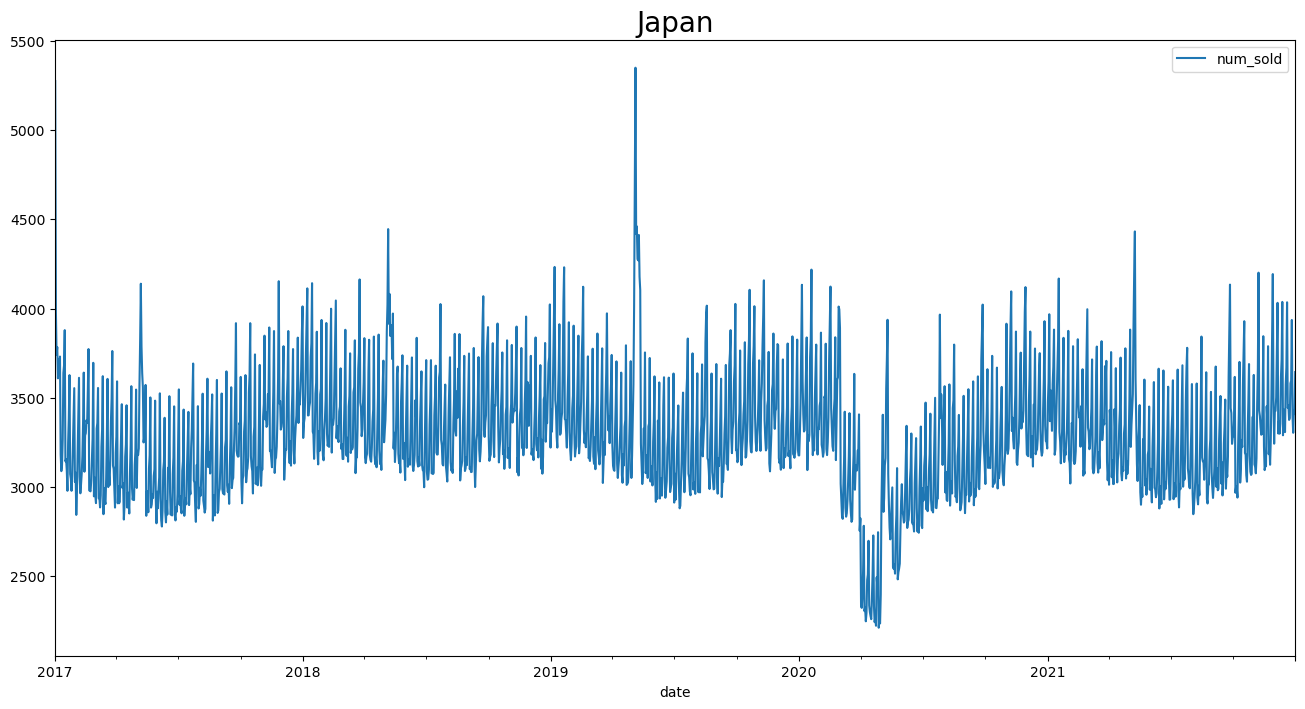

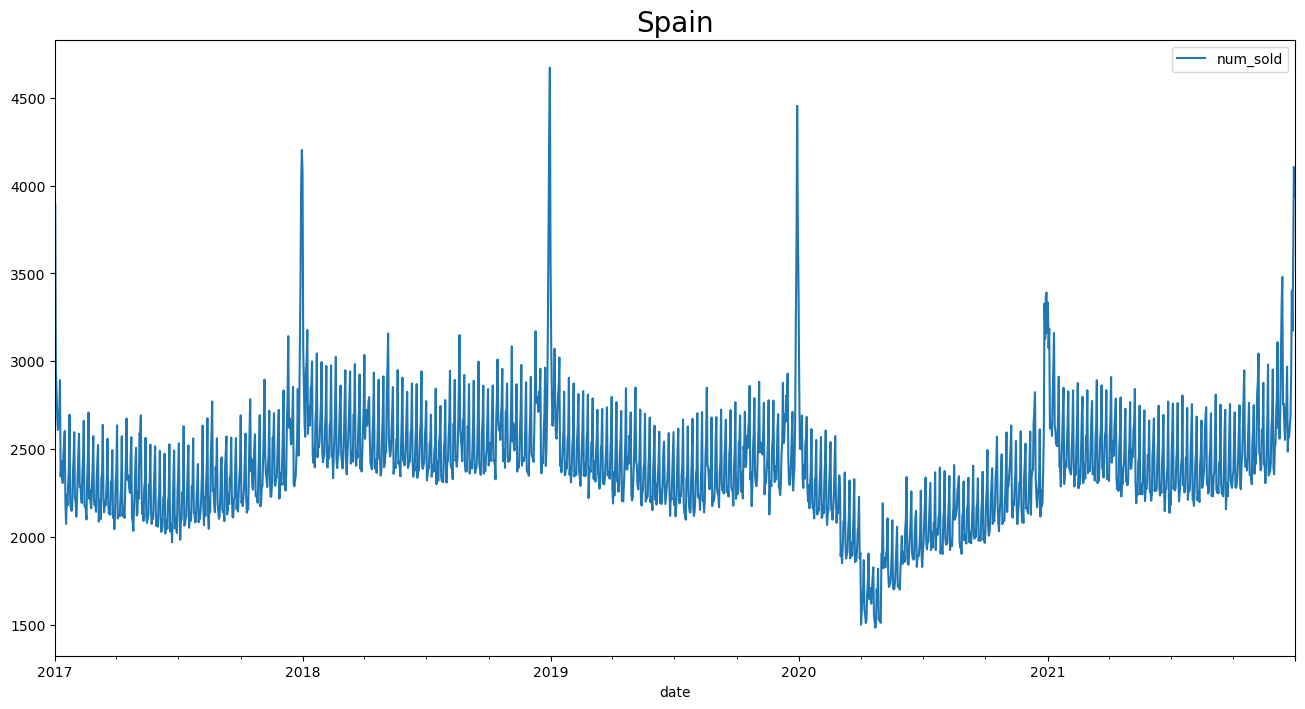

In [17]:
# Let's start from simple time-value plots

for i in tqdm(train['country'].unique()):
    
    data = train[train['country'] == i].groupby(['date']).agg({'num_sold':'sum'})
    
    fig, ax = plt.subplots(figsize=(16,8))

    data.plot(ax=ax)

    ax.set_title(i, size=20)

    plt.show()


The data looks stationary.

# Are Sales on the Country Level Stationary ?

In [18]:
from statsmodels.tsa.stattools import adfuller

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
# Let's start from simple time-value plots

for i in tqdm(train['country'].unique()):
    
    print('#######')
    print('')
    print(i)
    data = train[train['country'] == i].groupby(['date']).agg({'num_sold':'sum'})

    dftest = adfuller(data.num_sold, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    print('')

  0%|          | 0/5 [00:00<?, ?it/s]

#######

Argentina
1. ADF :  -1.8346267865109436
2. P-Value :  0.36341095476246305
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1800
5. Critical Values :
	 1% :  -3.4339881389288407
	 5% :  -2.863147035877915
	 10% :  -2.567625533641975

#######

Canada
1. ADF :  -0.6522828474800961
2. P-Value :  0.8587253662350269
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1801
5. Critical Values :
	 1% :  -3.4339861159726306
	 5% :  -2.863146142843122
	 10% :  -2.5676250581282964

#######

Estonia
1. ADF :  -0.47184911776644195
2. P-Value :  0.8973938732421303
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1801
5. Critical Values :
	 1% :  -3.4339861159726306
	 5% :  -2.863146142843122
	 10% :  -2.5676250581282964

#######

Japan
1. ADF :  -4.063641777157955
2. P-Value :  0.0011115817761391236
3. Num Of Lags :  24
4. Num Of Observat

Here we can see that the p-value is higher for our dataset, and we can say that the evidence of the null hypothesis is low; hence the time series is non-stationary. We can make the time series stationary with differencing methods.

# Stationarity transformation

In [20]:
(panel_train <= 0).sum().sum()

0

The num of sales cannot be negative or zero -> we can use log difference

In [21]:
panel_train = panel_train.sort_index()
panel_test = panel_test.sort_index()

In [22]:
panel_train_log_diff  = np.log(panel_train) - np.log(panel_train.shift(1))

In [23]:
panel_train_log_diff.head()

num_sold                                \
country                            Argentina                                 
store                           Kaggle Learn                                 
product    Using LLMs to Improve Your Coding Using LLMs to Train More LLMs   
date                                                                         
2017-01-01                               NaN                           NaN   
2017-01-02                         -0.211309                     -0.339507   
2017-01-03                         -0.147636                     -0.043485   
2017-01-04                          0.000000                     -0.068993   
2017-01-05                         -0.095310                      0.090972   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                            NaN   
2017-01-02                                      -0.251314   
2017-01-03                                       0.000000   
2017-01-04                                       0.000000   
2017-01-05                                      -0.154151   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                                    
2017-01-01                                        NaN   
2017-01-02                                  -0.316337   
2017-01-03                                  -0.047628   
2017-01-04                                  -0.024693   
2017-01-05                                  -0.025318   

                                                                         \
country                                                                   
store                                                      Kaggle Store   
product    Using LLMs to Write Better Using LLMs to Improve Your Coding   
date                                                                      
2017-01-01                        NaN                               NaN   
2017-01-02                  -0.336472                         -0.173272   
2017-01-03                   0.055570                         -0.145182   
2017-01-04                  -0.145182                          0.117783   
2017-01-05                   0.000000                         -0.087011   

                                          \
country                                    
store                                      
product    Using LLMs to Train More LLMs   
date                                       
2017-01-01                           NaN   
2017-01-02                     -0.241162   
2017-01-03                     -0.124298   
2017-01-04                     -0.029853   
2017-01-05                     -0.078781   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                            NaN   
2017-01-02                                      -0.241162   
2017-01-03                                       0.000000   
2017-01-04                                      -0.095310   
2017-01-05                                       0.000000   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                      

# Now Let's Check

In [24]:
for name, values in panel_train_log_diff.iteritems():
    print('######')
    print(name)
    dftest = adfuller(values.dropna(), autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    print('')

/tmp/ipykernel_20/1440557154.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in panel_train_log_diff.iteritems():


######
('num_sold', 'Argentina', 'Kaggle Learn', 'Using LLMs to Improve Your Coding')
1. ADF :  -10.886475657380645
2. P-Value :  1.256279647066676e-19
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1799
5. Critical Values :
	 1% :  -3.433990164137254
	 5% :  -2.8631479299063405
	 10% :  -2.567626009684832

######
('num_sold', 'Argentina', 'Kaggle Learn', 'Using LLMs to Train More LLMs')
1. ADF :  -11.992158632833853
2. P-Value :  3.5006617975859283e-22
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1799
5. Critical Values :
	 1% :  -3.433990164137254
	 5% :  -2.8631479299063405
	 10% :  -2.567626009684832

######
('num_sold', 'Argentina', 'Kaggle Learn', 'Using LLMs to Win Friends and Influence People')
1. ADF :  -12.300066040192812
2. P-Value :  7.485208055454817e-23
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1799
5. 

All Series became stationary

# Quick Summary

Currettly we have well balanced stationary panel.

Each TS represent Daily Sales where we have over 1825 points for 5 consecutive years.

In [25]:
panel_train_log_diff

num_sold                                \
country                            Argentina                                 
store                           Kaggle Learn                                 
product    Using LLMs to Improve Your Coding Using LLMs to Train More LLMs   
date                                                                         
2017-01-01                               NaN                           NaN   
2017-01-02                         -0.211309                     -0.339507   
2017-01-03                         -0.147636                     -0.043485   
2017-01-04                          0.000000                     -0.068993   
2017-01-05                         -0.095310                      0.090972   
...                                      ...                           ...   
2021-12-27                          0.075986                     -0.137201   
2021-12-28                         -0.075986                      0.257829   
2021-12-29                          0.191055                     -0.022990   
2021-12-30                         -0.021979                      0.022990   
2021-12-31                         -0.022473                      0.065958   

                                                           \
country                                                     
store                                                       
product    Using LLMs to Win Friends and Influence People   
date                                                        
2017-01-01                                            NaN   
2017-01-02                                      -0.251314   
2017-01-03                                       0.000000   
2017-01-04                                       0.000000   
2017-01-05                                      -0.154151   
...                                                   ...   
2021-12-27                                      -0.182322   
2021-12-28                                       0.182322   
2021-12-29                                       0.154151   
2021-12-30                                       0.000000   
2021-12-31                                      -0.154151   

                                                       \
country                                                 
store                                                   
product    Using LLMs to Win More Kaggle Competitions   
date                                                    
2017-01-01                                        NaN   
2017-01-02                                  -0.316337   
2017-01-03                                  -0.047628   
2017-01-04                                  -0.024693   
2017-01-05                                  -0.025318   
...                                               ...   
2021-12-27                                  -0.087011   
2021-12-28                                   0.114410   
2021-12-29                                   0.150282   
2021-12-30                                   0.022990   
2021-12-31                                  -0.022990   

                                                                         \
country                                                                   
store                                                      Kaggle Store   
product    Using LLMs to Write Better Using LLMs to Improve Your Coding   
date                                                                      
2017-01-01                        NaN                               NaN   
2017-01-02                  -0.336472                         -0.173272   
2017-01-03                   0.055570                         -0.145182   
2017-01-04                  -0.145182                          0.117783   
2017-01-05                   0.000000                         -0.087011   
...                               ...                               ...   
2021-12-27                  -0.068993                         -0.105361 

In [26]:
import statsmodels.api as sm

# SARIMAX

In [27]:
import statsmodels

In [28]:
Ex_Series_SARIMAX = panel_train_log_diff[[('num_sold', 'Argentina', 'Kaggle Learn', 'Using LLMs to Improve Your Coding')]].dropna()
Ex_Series_SARIMAX.columns = ['num_sold']

def create_sarimax(df: pd.DataFrame, y_t_name = 'num_sold') -> statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper:

    model=sm.tsa.statespace.SARIMAX(dates=df.index, freq='D', 
                                    endog=df[y_t_name].values, 
                                    order=(1, 1, 1),seasonal_order=(1,1,1,12))

    model=model.fit()
    
    return model

Ex_SARIMAX = create_sarimax(Ex_Series_SARIMAX)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.07457D-01    |proj g|=  1.82047D+00


 This problem is unconstrained.



At iterate    5    f= -4.79405D-01    |proj g|=  1.83073D+00

At iterate   10    f= -5.75171D-01    |proj g|=  8.15716D-01

At iterate   15    f= -7.14413D-01    |proj g|=  8.11833D-01

At iterate   20    f= -7.64206D-01    |proj g|=  4.01261D-02

At iterate   25    f= -7.74378D-01    |proj g|=  7.40927D-02

At iterate   30    f= -7.75846D-01    |proj g|=  2.03255D-02

At iterate   35    f= -7.75944D-01    |proj g|=  1.45919D-02

At iterate   40    f= -7.75947D-01    |proj g|=  7.10284D-03

At iterate   45    f= -7.75948D-01    |proj g|=  2.62442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     65   

/tmp/ipykernel_20/3267335559.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[pred[0]:pred[1],'forecast']=model.predict(start=pred[0],end=pred[1]-1,dynamic=True)


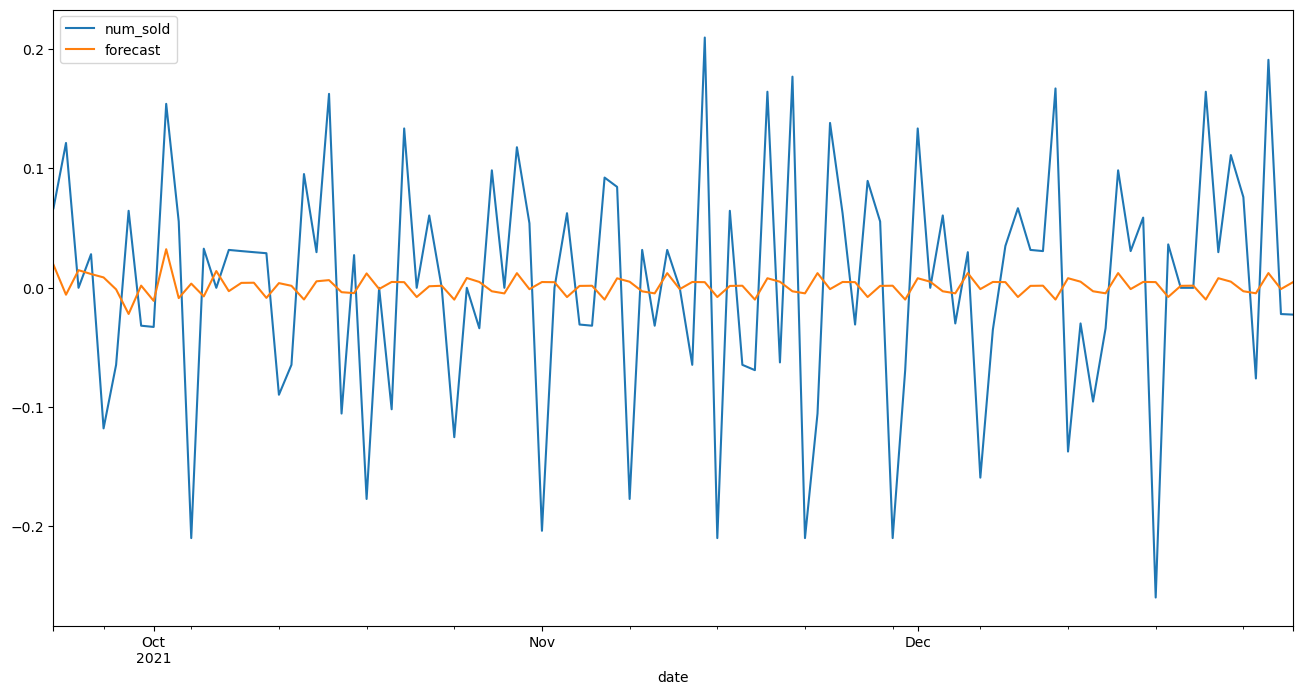

In [29]:
def predict_draw_sarimax(df: pd.DataFrame, model, pred = (1725,1825)) -> None:

    df.loc[pred[0]:pred[1],'forecast']=model.predict(start=pred[0],end=pred[1]-1,dynamic=True)
    
    df.iloc[pred[0]:pred[1]][['num_sold','forecast']].plot()

    plt.show()
    
predict_draw_sarimax(df=Ex_Series_SARIMAX, model=Ex_SARIMAX)

# Prophet

In [30]:
import prophet

In [31]:
Ex_Series_Prophet = panel_train_log_diff[[('num_sold', 'Argentina', 'Kaggle Learn', 'Using LLMs to Improve Your Coding')]].dropna()
Ex_Series_Prophet = Ex_Series_Prophet.reset_index()
Ex_Series_Prophet.columns = ['ds','y']

def create_prophet(df: pd.DataFrame, y_t_name = 'num_sold', valid_out: int = 100) -> prophet.forecaster.Prophet:

    model = Prophet()
    
    model = model.fit(df.iloc[:-valid_out]) # Model Will be Overwritten after call
    
    future_dataframe = model.make_future_dataframe(periods=valid_out)

    future_dataframe = model.predict(future_dataframe)
    
    return future_dataframe
    
Ex_Series_Prophet_Aug = create_prophet(Ex_Series_Prophet)

08:43:05 - cmdstanpy - INFO - Chain [1] start processing
08:43:05 - cmdstanpy - INFO - Chain [1] done processing


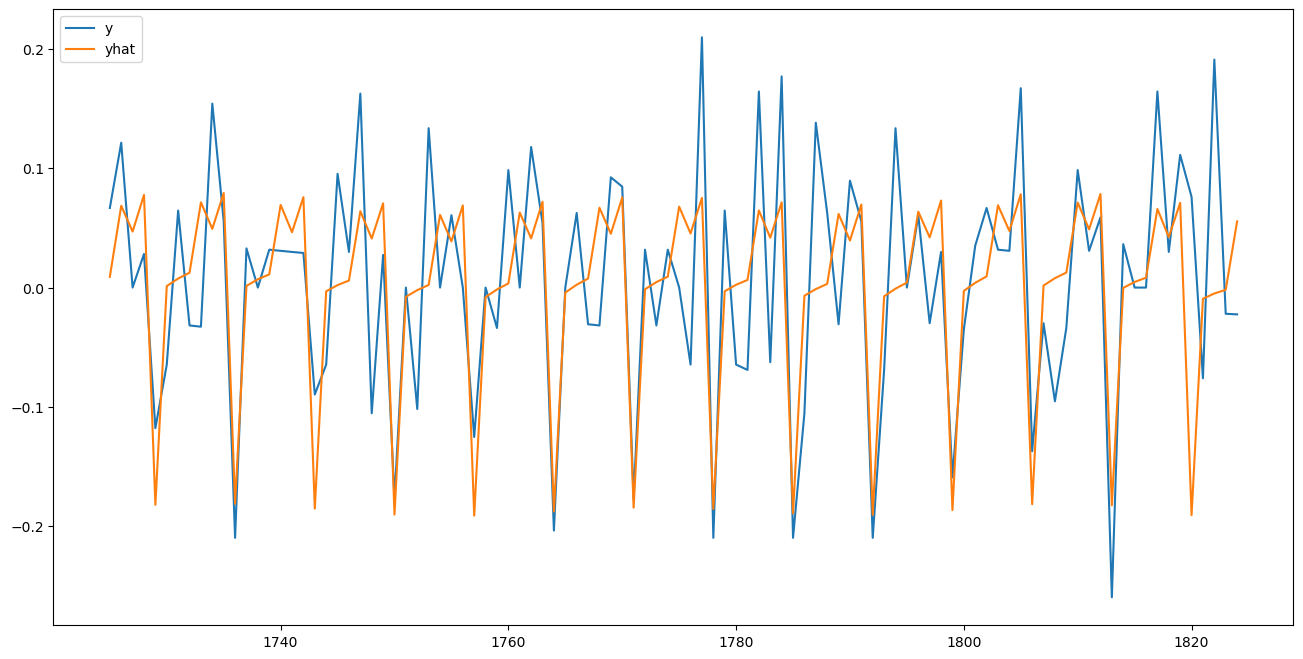

In [32]:
def predict_draw_prophet(df_train: pd.DataFrame, df_pred, pred = (1725,1825)) -> None:
    
    df = df_train.merge(df_pred, on='ds')
    
    df.iloc[pred[0]:pred[1]][['y','yhat']].plot()

    plt.show()
    
predict_draw_prophet(df_train=Ex_Series_Prophet, df_pred=Ex_Series_Prophet_Aug)